# (84100) Farnocchia orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

In [3]:
body_id = '84100'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = nongrav_info['radius']
de_kernel = 441

In [4]:
add_gaia_obs = False
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 943 observations from the MPC.
	Filtered to 943 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: UNK
	No debiasing needed for 505 observations.
	Debiased 416 observations.
	No bias information for 22 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 884 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 158 observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.430			 0.531			 530.981			 0.282
2			 0.429			 0.529			 528.616			 0.281
3			 0.429			 0.529			 528.616			 0.281
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.405			 0.500			 470.714			 0.251
5			 0.404			 0.500			 470.657			 0.251
Converged after rejecting outliers. Rejected 3 out of 943 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 5 (of 5):
RMS unweighted: 0.40439104667967135
RMS weighted: 0.49955286426108997
chi-squared: 470.65707906509175
reduced chi-squared: 0.25115105606461674
square root of reduced chi-squared: 0.5011497341759414
--------------------------------------------------------------
Solution Time: MJD 58042.000 TDB = 2017-10-16 00:00:00.000 TDB
Solution Observation Arc: 10342.85 days (28.32 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			2.02839420821e-01		1.41072497409e-09		2.02839395940e-01		3.51124905251e-08		-2.48812566661e-08		-17.637
q			2.17602309556e+00		5.02213641990e-09		2.17602316556e+00		9.42359491328e-08		+7.00038054191e-08		+13.939
tp			5.74182713236e+04		7.41859215578e-06		5.74182713063e+04		3.56858319889e-05		-1.73064254341e-05		-2.333
om			1.52357305306e+02		1.14596100392e-06		1.52357325384e+02		3.595750029

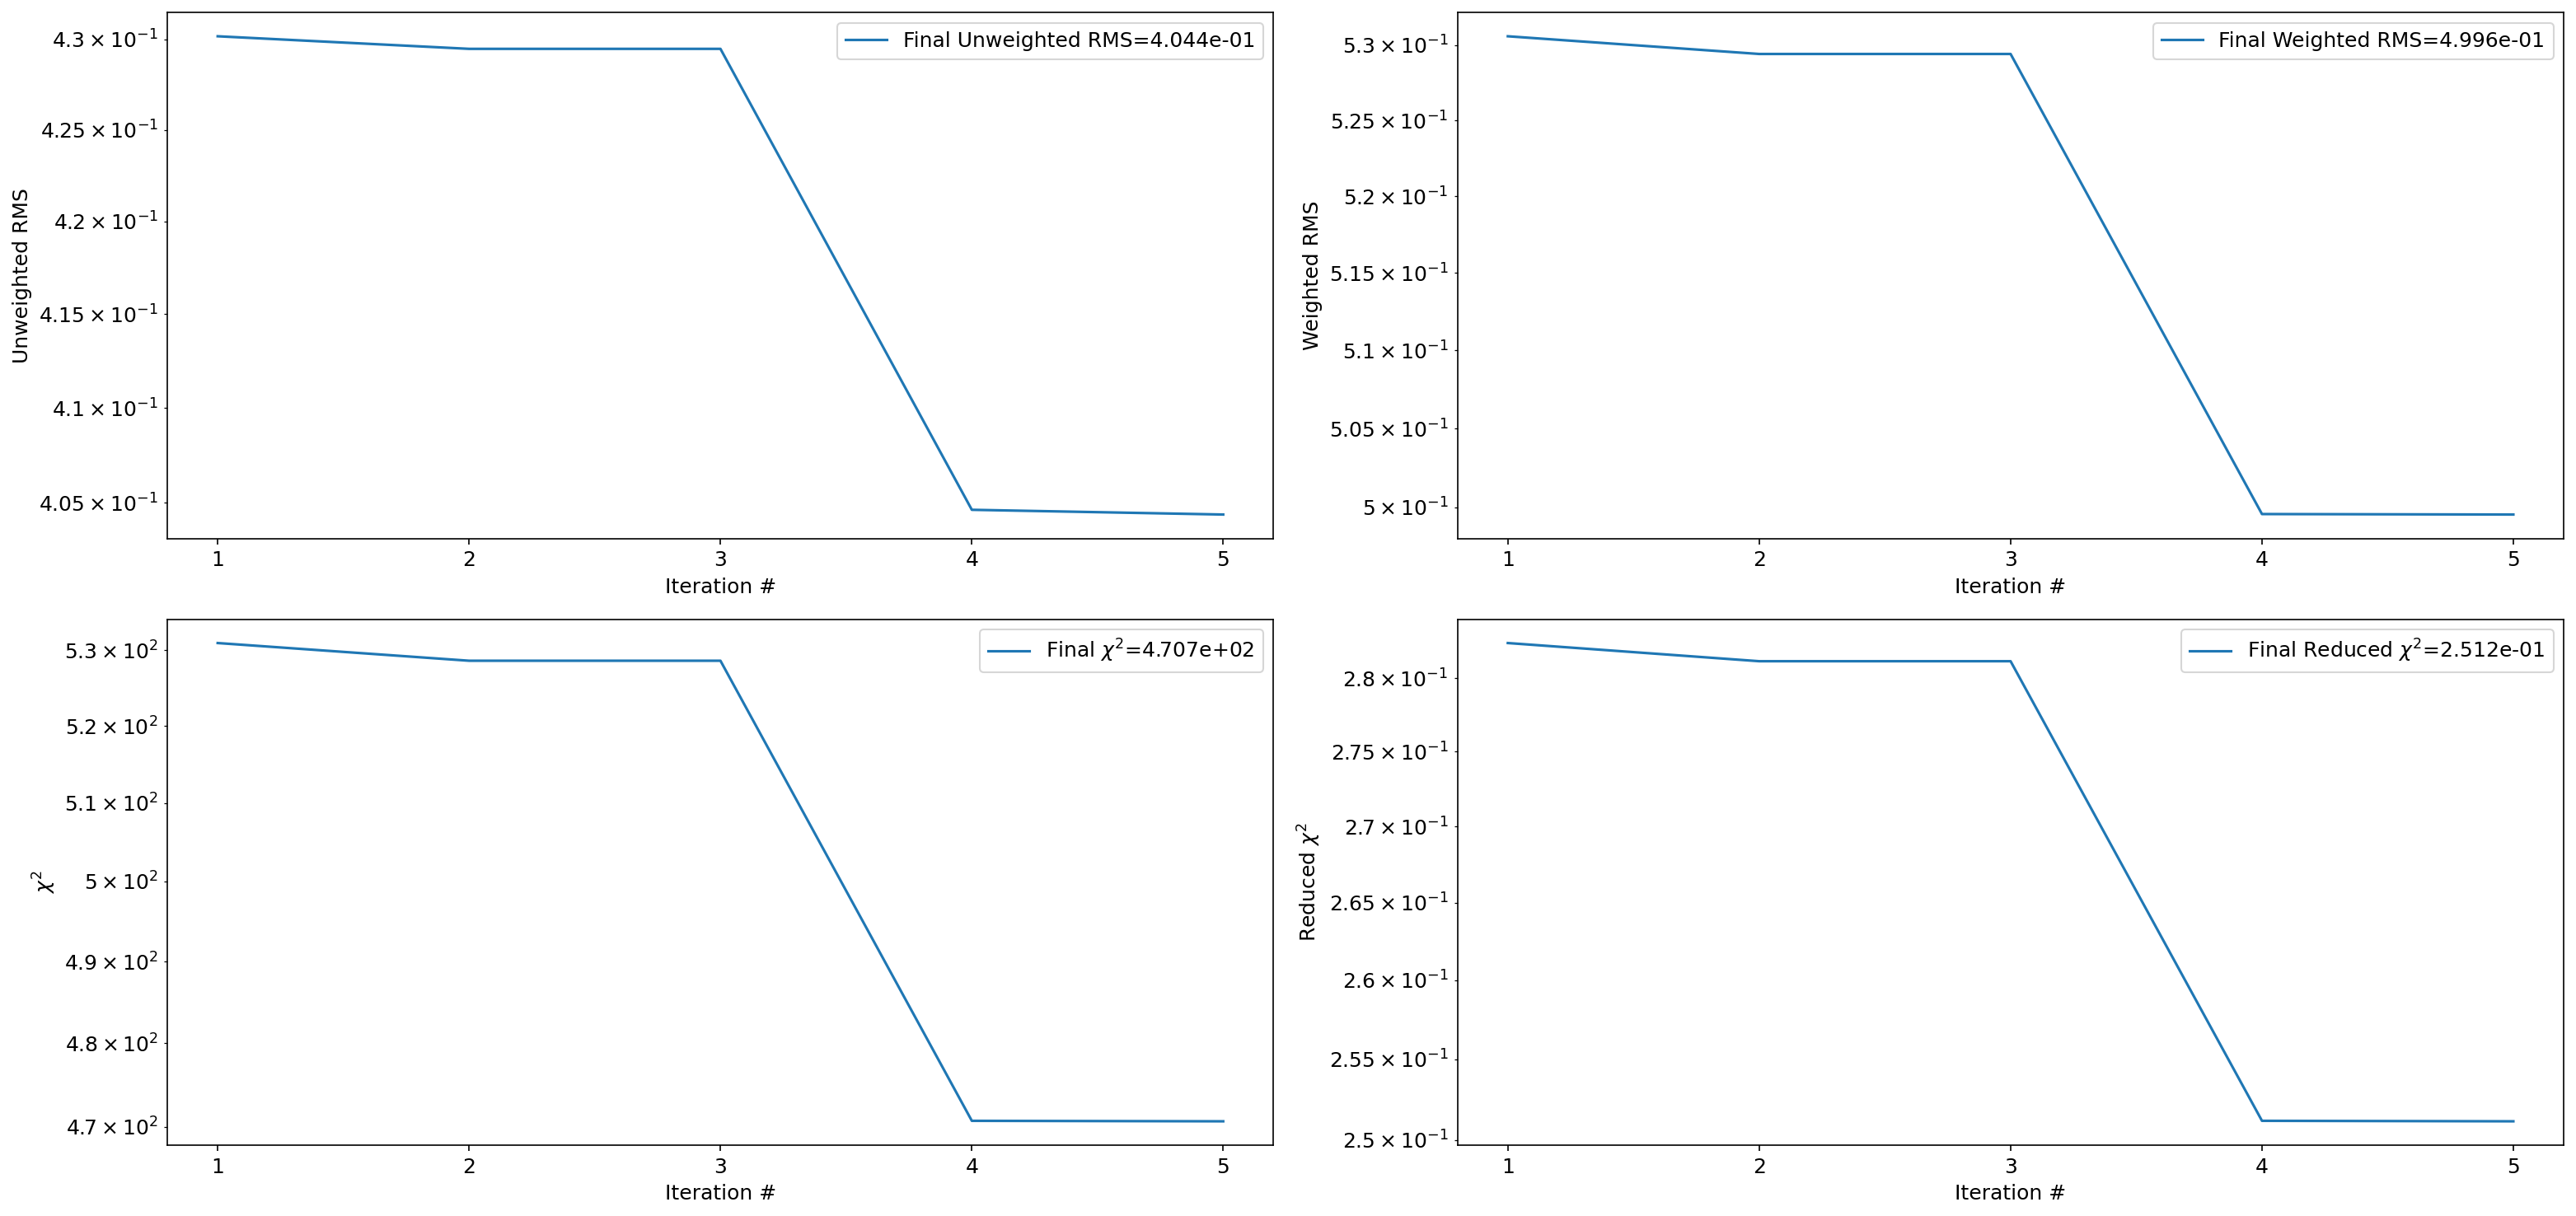

In [8]:
fit_sim.plot_summary(auto_close=True)

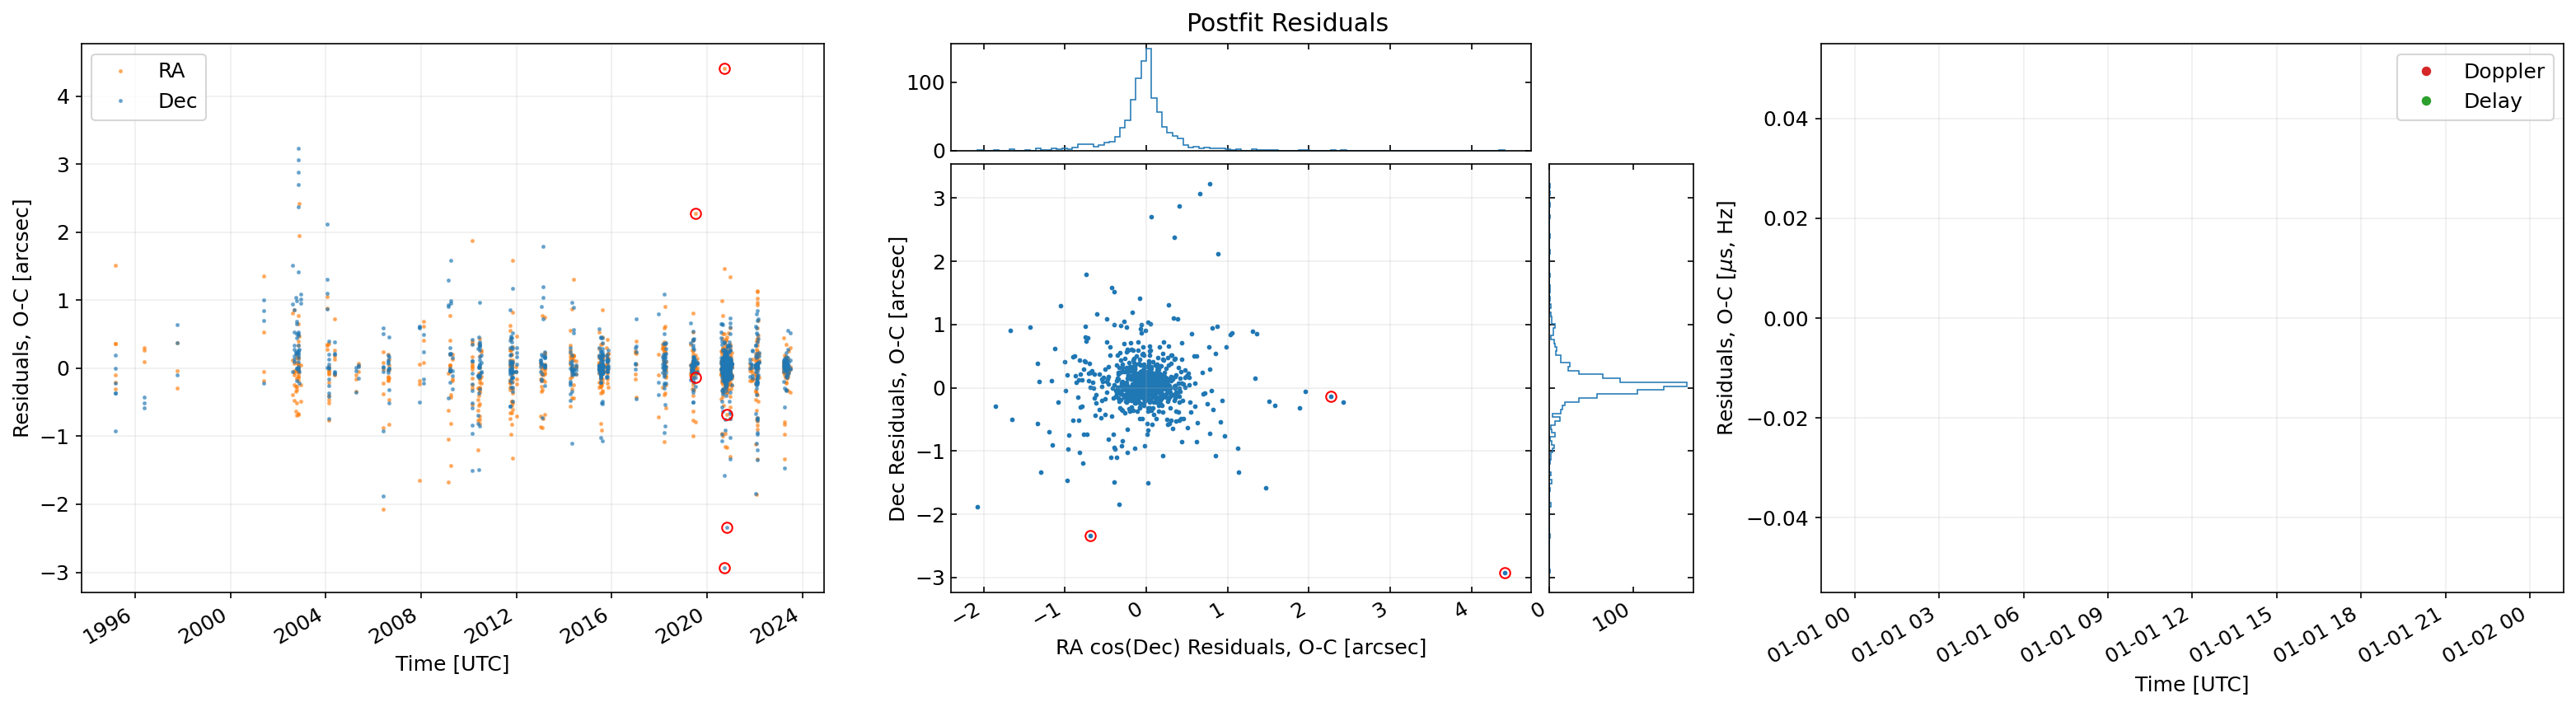

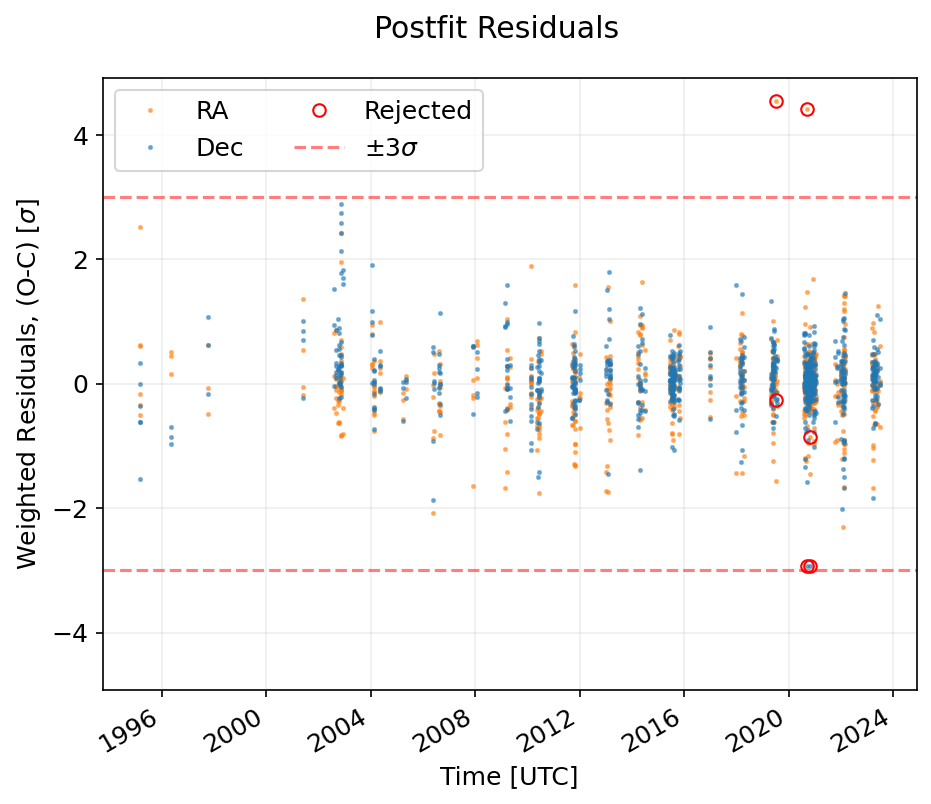

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 37.71
Mahalonobis distance between GRSS and JPL solution: 1.63
Bhattacharya distance between JPL and GRSS solution: 6.5007
Bhattacharya coefficient between JPL and GRSS solution: 0.0015


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90

AssertionError: 